In [1]:
import numpy as np
import matplotlib.pyplot as plt
import finesse
from finesse.analysis.actions import RunLocks, Noxaxis
from finesse import ligo
import warnings

warnings.filterwarnings('ignore')
finesse.configure(plotting=True)

In [2]:
fl = 1/2.898550724637681e-05
print(f"changed the lens* to len using diopters=1/f: {fl:.16f}")

changed the lens* to len using diopters=1/f: 34500.0000000000000000


1. It can't recognize lens* (use diopters instead of fl)
2. "ValueError: In block 'laser': jitter: Node 'ni' already assigned to 'L0'.": added a space of zero between laser and jitter (s L0Jitter 0 ni njitter)
3. "In block 'squeezer': M1_OPO: Node 'nSQZ' already assigned to 'sqz'.": similar solution as above (s sqzM1_OPO 0 nSQZ nM1_OPO). But also need to make the change (gauss* g_nSQZ M1_OPO nM1_OPO -0.054 0.139036143294069 since nSQZ is no longer a node of M1_OPO component)

In [3]:
kat = finesse.Model()
kat.parse_legacy_file("./LLO.kat")
print(kat.unparse()[:97])
print("#### The parse_legacy_file function worked! ####")

laser L0 P=40.0
space L0Jitter portA=L0.p1 portB=jitter.p1
beamsplitter jitter R=1.0 T=0.0 L=0.0

#### The parse_legacy_file function worked! ####


In [4]:
out = kat.run()

print(out.detectors)
print(out.data)

()
()


In [5]:
LIGO = ligo.make_aligo(RF_AS_readout=False, verbose=True)

Lock('CARM_lock') REFL9_I -0.00010310899995708841
Lock('MICH_lock') POP45_Q 16.69737563119658
Lock('PRCL_lock') POP9_I -2.923409080736336
Lock('SRCL_lock') POP45_I -43.220106415336616
Lock('DARM_rf_lock') AS45_I -0.00339832744582408
Lock('DARM_dc_lock') AS_DC nan


In [6]:
LLO = LIGO.deepcopy()

In [10]:
DBSDebug = LLO.deepcopy()
DBSDebug.parse("""
pd PXarm ETMX.p1.o
pd PYarm ETMY.p1.o
pd POMC SRMAR.p2.o
""")
outDebug = DBSDebug.run(Noxaxis(pre_step=RunLocks(method='newton', 
                                                   display_progress='false', max_iterations=1000)))
# outDebug['DBS2']-outDebug['DBS1'], outDebug['DBS3']-outDebug['DBS1'], outDebug['DBS4']-outDebug['DBS1']
outDebug['PXarm'], outDebug['PYarm'], outDebug['POMC'], 

Error Signal Residuals at Each Iteration (W):
                          CARM_lock      MICH_lock      PRCL_lock      SRCL_lock    DARM_dc_lock  
                          REFL9_I1       POP45_Q1        POP9_I1       POP45_I1        AS_DC1     
Iteration Number    0      3.31e-05       4.58e-08       5.09e-07       1.92e-07      -6.61e-03   
Iteration Number    1      7.68e-09      -6.85e-12       1.65e-10       4.64e-11       8.15e-04   
Iteration Number    2     -9.50e-10       8.60e-13      -2.04e-11      -5.70e-12      -1.89e-04   
Iteration Number    3      2.20e-10      -1.99e-13       4.72e-12       1.32e-12       4.15e-05   
Iteration Number    4     -4.83e-11       4.37e-14      -1.04e-12      -2.90e-13      -9.22e-06   
Iteration Number    5      1.08e-11      -9.72e-15       2.31e-13       6.45e-14       2.05e-06   
Iteration Number    6     -2.40e-12       2.11e-15      -5.17e-14      -1.43e-14      -4.54e-07   


(248802.79737404673, 248795.20185428637, 0.35321397607061633)

In [37]:
LLONoOutputOptics = LLO.deepcopy()

LLONoOutputOptics.parse("""
###########################################################################
### pendulum for QRPN
variable Mitmy 39.420 
variable Metmy 39.642
variable Mitmx 39.603
variable Metmx 39.508

pendulum itmx_sus ITMX.mech mass=&Mitmx fz=1 Qz=1M
pendulum etmx_sus ETMX.mech mass=&Metmx fz=1 Qz=1M
pendulum itmy_sus ITMY.mech mass=&Mitmy fz=1 Qz=1M
pendulum etmy_sus ETMY.mech mass=&Metmy fz=1 Qz=1M
    
fsig(1)
sgen darmx LX.h
sgen darmy LY.h phase=180
    
# Output the full quantum noise limited sensitivity
qnoised qnoise OMC.p2.o nsr=True
xaxis(darmx.f, log, 5, 5k, 100, pre_step=run_locks(method='newton', display_progress=false))
""")

outLLONoOutputOptics = LLONoOutputOptics.run()

In [38]:
# np.save("./LLOWithoutOutputOptics.npy", outLLONoOutputOptics["qnoise"].real)

In [41]:
removeElements = [
"# Here we just use some simple filter to approximate an OMC for filtering",
"# out RF fields, this doesn't filter HOMs!",
"dbs OFI",
"sq sqz db=6 angle=90.0",
"obp OMC fc=0 bandwidth=1M filter_hom=[=0,0]",
"pd Pas OMC.p2.o",
"space sqz_p1__OFI_p2 portA=sqz.p1 portB=OFI.p2 auto_generated=true",
"space SRMAR_p2__OFI_p1 portA=SRMAR.p2 portB=OFI.p1 auto_generated=true",
"space OFI_p3__OMC_p1 portA=OFI.p3 portB=OMC.p1 auto_generated=true",
"readout_dc AS    OMC.p2.o output_detectors=true",
"lock DARM_dc_lock AS_DC DARM.DC -0.01 1e-6  disabled=false offset=20m"

]

unparsed = LIGO.unparse()
for ele in removeElements:
    unparsed = unparsed.replace(ele, '')
    
print(unparsed)
LLO = finesse.Model()
LLO.parse(unparsed)

regeneration of original KatScript for operations not implemented yet
regeneration of original KatScript for operations not implemented yet
regeneration of original KatScript for operations not implemented yet
regeneration of original KatScript for operations not implemented yet
regeneration of original KatScript for operations not implemented yet
regeneration of original KatScript for operations not implemented yet
regeneration of original KatScript for operations not implemented yet
regeneration of original KatScript for operations not implemented yet
regeneration of original KatScript for operations not implemented yet
regeneration of original KatScript for operations not implemented yet
regeneration of original KatScript for operations not implemented yet
regeneration of original KatScript for operations not implemented yet
regeneration of original KatScript for operations not implemented yet
regeneration of original KatScript for operations not implemented yet
regeneration of orig


# modulators for core interferometer sensing - Advanced LIGO, CQG, 2015
# http://iopscience.iop.org/article/10.1088/0264-9381/32/7/074001/meta#cqg507871s4-8
# 9MHz (CARM, PRC, SRC loops)
variable f1 9099471
variable f2 (5*&f1)
variable nsilica 1.45
variable Mloss 30u
###############################################################################
###   length definitions
###############################################################################
variable Larm 3994
variable LPR23 16.164  # distance between PR2 and PR3
variable LSR23 15.443  # distance between SR2 and SR3
variable LPR3BS 19.538 # distance between PR3 and BS
variable LSR3BS 19.366 # distance between SR3 and BS
variable lmich 5.342   # average length of MICH
variable lschnupp 0.08
variable lPRC ((3.5*299792458.0)/(2*&f1)) # T1000298 Eq2.1, N=3
variable lSRC ((17*299792458.0)/(2*&f2)) # T1000298 Eq2.2, M=3
###############################################################################
###   laser
#######################

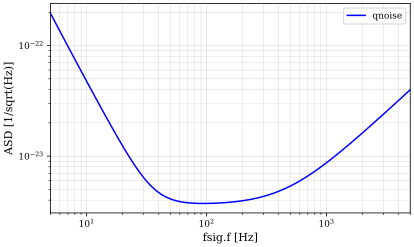

In [43]:
LLO.Mloss.value = 3.75e-05

LLO.parse("""
    s sSRM_FI SRMAR.p2 FI2.p1 0.7278
   
    ###########################################################################

    # (Loctions and angles based on the solid work file D1000342-v14 give ~5% 
    # mismatch. Thus lom1, lom3omc have been adjusted to get ~99.7% overlap at the OMC)

    # Distance SRM --> Faraday Isolator (FI)


    # Directional beam splitter (ideal Faraday Isolator with 4 ports)
    # ----------------------------------------------------------------
    # Description of node connections, inputNode --> outputNode
    # --
    # nFI2a (SRM)    --> nFI2c (OMC)
    # nFI2b (SQZ)    --> nFI2a (SRM)
    # nFI2c (OMC)    --> nFI2d (Unused)
    # nFI2d (Unused) --> nFI2b (SQZ)

    dbs FI2

    # Distance FI2 --> OM1  
    s sFI_OM1 FI2.p3 OM1.p1 2.9339

    # OM1
    bs OM1 T=800u L=&Mloss phi=0 alpha=2.251 Rc=4.6# T is set for high power; Loss is a guess

    # Distance OM1 --> OM2
    s sOM1_OM2 OM1.p2 OM2.p1 1.395 

    # OM2
    bs OM2 T=10u L=&Mloss phi=0 alpha=4.399 Rc=1.7058 # T is a guess

    # Distance OM2 --> OM3

    s sOM2_OM3 OM2.p2 OM3.p1 0.631
    bs OM3 T=10u L=&Mloss phi=0 alpha=30.037 # T is a guess

    # Distance OM3 --> OMC input coupler IC
    s sOM3_OMC OM3.p2 OMC_IC.p1 0.2034 # By design should be ~0.31

    ###########################################################################
    ### FTend FI

    ### FTblock OMC
    ###########################################################################
    # OMC (as built parameters: D1300507-v1)

    # Input Coupler IC (flat mirror)
    bs OMC_IC T=0.0076 L=10u phi=0 alpha=2.7609

    # Distance from IC to OC  
    s lIC_OC OMC_IC.p3 OMC_OC.p1 0.2815

    # Output Coupler OC (flat mirror)
    bs OMC_OC T=0.0075 L=10u phi=0 alpha=4.004

    # Distance from OC to CM1
    s lOC_CM1 OMC_OC.p2 OMC_CM1.p1 0.2842

    # Curved Mirror CM1
    bs OMC_CM1 T=36u L=10u phi=0 alpha=4.004 Rc=2.57321
    
    # Distance from CM1 to CM2 
    s lCM1_CM2 OMC_CM1.p2 OMC_CM2.p1 0.2815

    # Curved Mirror CM2
    bs OMC_CM2 T=35.9u L=10u phi=0 alpha=4.004 Rc=2.57369

    # Distance from CM2 to IC
    s lCM2_IC OMC_CM2.p2 OMC_IC.p4 0.2842

    ###########################################################################
    ### FTend OMC
    cav cavOMC OMC_OC.p1.o

    ###########################################################################
    ### replace the elements that have been removed
    pd Pas OMC_OC.p3.o
    readout_dc AS OMC_OC.p3.o output_detectors=true
    lock DARM_dc_lock AS.outputs.DC DARM.DC -0.01 1e-6  disabled=false offset=20m
    
    ###########################################################################
    
    ###########################################################################
    ### pendulum for QRPN
    variable Mitmy 39.420 
    variable Metmy 39.642
    variable Mitmx 39.603
    variable Metmx 39.508
    
    pendulum itmx_sus ITMX.mech mass=&Mitmx fz=1 Qz=1M
    pendulum etmx_sus ETMX.mech mass=&Metmx fz=1 Qz=1M
    pendulum itmy_sus ITMY.mech mass=&Mitmy fz=1 Qz=1M
    pendulum etmy_sus ETMY.mech mass=&Metmy fz=1 Qz=1M
    
    fsig(1)
    sgen darmx LX.h
    sgen darmy LY.h phase=180

    # Output the full quantum noise limited sensitivity
    qnoised qnoise OMC_OC.p3.o nsr=True
    xaxis(darmx.f, log, 5, 5k, 100, pre_step=run_locks(method='newton', display_progress=false))
""")

out = LLO.run()
out.plot("qnoise", log=True, separate=False);

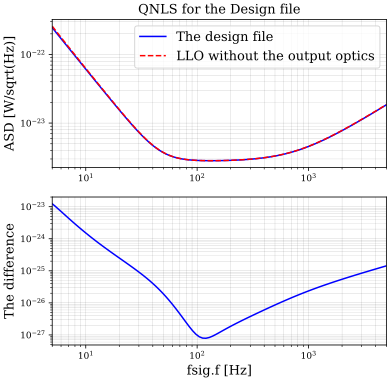

In [31]:
outF2 = np.load("./F2 code/QNLSDesignF2.npy")

fig,ax =plt.subplots(2,1,figsize=(6,6))
x = out.x[0]

ax[0].loglog(x, outF2, label="The design file")
ax[0].loglog(x, out["qnoise"].real, 'r--', label="LLO without the output optics")
ax[0].set_ylabel("ASD [W/sqrt(Hz)]", fontsize=13)
ax[0].legend(loc = 'best', fontsize=13)

ax[1].loglog(x, np.abs(outF2-out["qnoise"].real))
ax[1].set_ylabel("The difference", fontsize=13)
ax[1].set_xlabel("fsig.f [Hz]", fontsize=13);

ax[0].set_title("QNLS for the Design file", fontsize=13);
# fig.savefig('./strain_sensitivityDesignF2and3.pdf')

In [32]:
# np.save("./QNLSDesignF3.npy", out["qnoise"].real)

In [8]:
###########################################################################
# Constants
###########################################################################

# Refractive indices
LLO.nsilica.value = 1.44963098985906   # From other kat-files. Consistent with [7].
n_tgg = 1.954 #from [14]
n_calcite = 1.65846 #from [14]  LT: The above two values are not used
###########################################################################
# Input
###########################################################################

# Input power [W]
LLO.L0.P = 40

# Modulation frequencies [Hz], from [1, 4].
LLO.f1.value = 9099055.0
LLO.f2.value = 45495275.0
if (5 * LLO.f1.value != LLO.f2.value):
    print(" ** Warning: modulation frequencies do not match: 5*f1!=f2")

# Modulation depths [rad], from [1], derived from [4].
LLO.mod1.midx = 0.13
LLO.mod2.midx = 0.139985


###########################################################################
# PRC
###########################################################################

# Lengths [m] from [1, 2].
# Radii of curvature [m] from [1, 3].
# Power reflections, transmissions and losses from [1, 3].
# Mass from [3].
# Thickness from [5].

# Spaces
# --------------------------
LLO.lp1.L = 16.6107     # PRM to PR2
LLO.lp2.L = 16.1648     # PR2 to PR3
LLO.lp3.L = 19.5380     # PR3 to BS
# Derived lpr length
lpr = LLO.lp1.L + LLO.lp2.L + LLO.lp3.L

# PRM (PRM 02 [3],checked 2018.11.21)
# --------------------------
#PRM (HR)
# -------------
LLO.PRM.T = 0.03123                      # [1] using 0.03, 3.123%pm0.009957 from E1200100-v1
LLO.PRM.L = (5.4 + 0.5)*1e-6             # Scatter + absorbtion
LLO.PRM.R = 1.0 - LLO.PRM.T - LLO.PRM.L  # = 0.9689941
LLO.PRM.Rc = 11.009                      # sign positive in other Finesse-files, matching that here (-ve in [3])
#LLO.PRM.mass = 2.890                    # Unused. [1] using 2.9 kg.
#PRM substrate
# -------------
LLO.sPRMsub1.L = 73.7e-3                 # From [5] (E1200438-v1) (average top and bottom). 0.075 in [1]. L: 74.9 mm in [1] (mean).

#PRMAR
# -------------
R_prm_ar = 26.0e-6                       
L_prm_ar = 11.45e-6                      # Absorbtion (not used in [1]?)
LLO.PRMAR.T = 1.0 - R_prm_ar - L_prm_ar  # = 0.99996255
LLO.PRMAR.R = 0                          # Adding reflection to loss due to the wedge.
LLO.PRMAR.L = L_prm_ar + R_prm_ar        # See above.

# PR2 (PR2 02 [3],checked 2018.11.21)
# --------------------------
#PR2 (HR)
# -------------
LLO.PR2.T = 243.0e-6
LLO.PR2.L = (8.0 + 0.6)*1e-6            # Scatter + absorbtion
LLO.PR2.R = 1.0 - LLO.PR2.T - LLO.PR2.L # = 0.9997484
LLO.PR2.Rc =  -4.545                    # [1] using -4.548 from PR2 03 (listed as spare), -4.5443 (T1200116-v1)
#LLO.PR2.mass = 2.899                   # Unused. [1] using 2.9 kg
#PR2AR (Unused) 
# -------------
#kat.PR2AR.R = 19e-6                    # Unused. [1] using 0.18 % (from PR2 03 @ 532 nm?)

# PR3 (PR3 03 [3],checked 2018.11.21)
# --------------------------
#PR3 (HR)
# -------------
LLO.PR3.T = 5.3e-6
LLO.PR3.L = (16.0 + 1.0)*1e-6
LLO.PR3.R = 1.0 - LLO.PR3.T - LLO.PR3.L # = 0.9999894
LLO.PR3.Rc = 36.027                     # [1] using 36.013 (to remove warnings(?))
#LLO.PR3.mass = 12.145                  # Unused. [1] using 12 kg. 
#PR2AR (Unused)
# -------------
#LLO.PR3AR.R = np.NaN                   # Not measured and unused. [1] using 20 ppm.

###########################################################################
# Beam splitter (BS 02)
###########################################################################

# Power reflections, transmissions and losses from [1, 3].
# Thickness [m] from [6], averaged over the 4 values.  

# Refl, Trans, and loss.
#  - HR
LLO.BS.T = 0.5
LLO.BS.L = (8.0 + 0.6)*1e-6           # [2] using 30 ppm 
LLO.BS.R = 1.0 - LLO.BS.T - LLO.BS.L  # = 0.4999914
#  - AR1
R_bs_ar = 30e-6                      
L_bs_ar = 1.7e-6                      # Not set in [1]
LLO.BSAR1.R = 0
LLO.BSAR1.T = 1.0 - R_bs_ar - L_bs_ar # = 0.9999683
LLO.BSAR1.L = L_bs_ar + R_bs_ar
#  - AR2
LLO.BSAR2.R = 0
LLO.BSAR2.T = 1.0 - R_bs_ar - L_bs_ar  # = 0.9999683
LLO.BSAR2.L = L_bs_ar + R_bs_ar

# Angles of incidence
#HR
alpha_in_hr =  45                     # Angle of incidence HR [deg], seen from laser side. 
LLO.BS.alpha = alpha_in_hr
#AR
alpha_out_hr = np.arcsin(np.sin(alpha_in_hr*np.pi/180.0)/LLO.nsilica.value)*180.0/np.pi # = 29.195033 # Angle of refraction HR
alpha_in_ar = alpha_out_hr            # Angle of incidence AR [deg]
LLO.BSAR1.alpha = alpha_in_ar         # Check! Signs swapped in other kat-files.
LLO.BSAR2.alpha = -alpha_in_ar

# Propagation distance through substrate
th_bs = 60.12e-3                     # Not set in [1].
th_bs_beam = th_bs/np.cos(alpha_out_hr*np.pi/180.0) # = 0.06887 # Thickness seen from beam
LLO.BSsub1.L = th_bs_beam
LLO.BSsub2.L = th_bs_beam

# Mass (unused)
#LLO.BS.mass = 14.211                # Unused. [1] using 14.2 kg.


###########################################################################
# Y - arm 
###########################################################################

# Lengths from [1, 2, 7]. Positions of ITMY AR and CP1 X and Y from [7].
# Refl, Trans, loss, masses [kg], RoCs [m] from [3].
# ITM Thickness from [8], averaged over the 4 values.
# CP03 Thickness from [9], averaged over the 4 values. 

# Lengths
# --------------------------
#ARM length
LLO.LY.L = 3994.4850                        # From [1, 2], [7] has 3 cm diff in ETMY position.
#inner mich length
L_bs_cpy = 4.8470                           # BS HR to CPY1 (no CP in [1])
th_cpy = 0.10001                            # CPY (CP 03 [3],checked 2018.11.21) thickness. No CP in [1])
L_cpy_itmy = 0.0200                         # CPY2 to ITMY AR (no CP in [1])
L_bs_itmy = L_bs_cpy + th_cpy*LLO.nsilica.value + L_cpy_itmy  # = 5.0120

isCP = False
if isCP:
    LLO.lBS2CPY.L = L_bs_cpy    
    LLO.lCPY2ITMY.L = L_cpy_itmy
else:
    LLO.ly1.L = L_bs_itmy

# ITMY (ITM 08 [3],checked 2018.11.21)
# --------------------------
# ITMY HR
LLO.ITMY.T = 0.0148                          # 1.48 ppm in [1] (E1200575-v2 -- 0.0148 ± 0.0003)
LLO.ITMY.L = 26.5E-6#(14.0 + 0.3)*1e-6               # Scatter + absorbtion. [1] has modified this to 65 ppm to get correct PRC gain.
                                             # (E1200574-v2 -- 13.5 ± 2 ppm)+(E1200577-v2 -- 0.3 ± 0.1 ppm)
LLO.ITMY.R = 1.0- LLO.ITMY.T - LLO.ITMY.L    # = 0.98518570
# ITMY AR
R_itmy_ar = 250e-6                           # 250 ppm in [1] (E1200576-v2 -- 250 ± 5 ppm)
L_itmy_ar = 0.6e-6                           # Absorbtion. Not set in [1]. (E1200577-v2 -- 0.6 ± 0.1 ppm)
LLO.ITMYAR.T = 1.0 - R_itmy_ar - L_itmy_ar   # = 0.9997494
LLO.ITMYAR.R = 0                             # Putting Refl on loss for AR due to wedge. (E1200576-v2 -- 250 ± 5 ppm)
LLO.ITMYAR.L = L_itmy_ar + R_itmy_ar
# Thickness
LLO.ITMYsub.L = 0.19929                      # Not set in [1].
# RoC
LLO.ITMY.Rc = -1940.7
# Mass
LLO.ITMY.mass = 39.420                        # [1] using 40 kg.  
# Lensing - From other kat-file. Check!
TLY_f = 34.5e3                                # Thermal lens ITMY, focal length
SLY_f = np.inf  # Constant ITMY substrate lens, focal length

splitlens = False
if splitlens:
    LLO.ITMYlens.f = SLY_f
    LLO.ITMY_therm.f = TLY_f
else:
    LLO.ITMYlens.p = 1/TLY_f + 1/SLY_f   # combined effect, focussing power

# ETMY (ETM 15, installed after O2 [3], checked 2018.11.21)
# --------------------------
#ETMY HR
LLO.ETMY.T = 3.9e-6 
LLO.ETMY.L = 40.0E-6#(9.1 + 0.21)*1e-6                 # Scatter+absorbtion, [1] has modified this to 30  ppm to correct cavity gains.
LLO.ETMY.R = 1.0 - LLO.ETMY.T - LLO.ETMY.L    # = 0.9999871
#ETMY AR
R_etmy_ar = 1.6e-6                            # 23 ppm in [1]. L:230ppm numbers of o1 and o2
L_etmy_ar = 0                                 # Unknown
LLO.ETMYAR.R = 0                              # Putting Refl on loss for AR due to wedge.
LLO.ETMYAR.T = 1.0 - R_etmy_ar - L_etmy_ar    # = 0.99977
LLO.ETMYAR.L = L_etmy_ar + R_etmy_ar
# Thickness
LLO.ETMYsub.L = 200.35e-3
# RoC
LLO.ETMY.Rc = 2245.4                          # [3], [1] uses 2239.7, 2249.86 in C1106295-v2
# Mass
LLO.ETMY.mass = 39.642                       # [1] using 40 kg.  

# CPY (CP 03) [3], checked 2018.11.21.  (No CP in [1])
# -------------

isCP = False
if isCP:
    # Loss
    L_cpy1 = 0.55e-6
    L_cpy2 = 0.57e-6
    # Refl
    R_cpy1 = 67e-6
    R_cpy2 = 15e-6
    # Trans
    T_cpy1 = 1.0 - R_cpy1 - L_cpy1
    T_cpy2 = 1.0 - R_cpy2 - L_cpy2
    if 'CPY1' in kat.components:
        LLO.CPY1.R = R_cpy1
        LLO.CPY1.T = T_cpy1
        LLO.CPY1.L = L_cpy1
        LLO.CPY2.R = R_cpy2
        LLO.CPY2.T = T_cpy2
        LLO.CPY2.L = L_cpy2
    else:
        LLO.CPYar1.R = R_cpy1
        LLO.CPYar1.T = T_cpy1
        LLO.CPYar1.L = L_cpy1
        LLO.CPYar2.R = R_cpy2
        LLO.CPYar2.T = T_cpy2
        LLO.CPYar2.L = L_cpy2
    # Thickness
    LLO.sCPY.L = th_cpy

# Derived Optical distances
L_bshr_itmyhr = L_bs_itmy + LLO.ITMYsub.L*LLO.nsilica.value   # = 5.3009. [1] using 5.3044

###########################################################################
# X - arm
###########################################################################

# Lengths
# --------------------------
#ARM length
LLO.LX.L = 3994.4850                       # Positions from [2].
#Inner Mich length
L_bs_cpx = 4.8295                          # Position of BSar from [2], position of CPX1 from [2,7].
th_cpx = 0.10011                           # CPX (CP 06) Thickness, average from [10] 
L_cpx_itmx = 0.0200                        # Position of CPX2 from [2,7]. Position of ITMX AR from [7]. Consistent with [2].
L_bsar_itmx = L_bs_cpx + th_cpx*LLO.nsilica.value + L_cpx_itmx   # = 4.9946
if isCP:
    LLO.lBS2CPX.L = L_bs_cpx    
    LLO.lCPY2ITMX.L = L_cpy_itmx
else:
    LLO.lx1.L = L_bsar_itmx

# ITMX (ITM 04 [3],checked 2018.11.21)
# --------------------------
#ITMX HR
LLO.ITMX.T = 0.0148                        # 1.48 ppm in [2][3][1] (missing %?) L:good (E1200702-v1 -- 0.0148 ± 0.0003)
LLO.ITMX.L = 26.0E-6#(10.0 + 0.4)*1e-6             # [1] 65 ppm, adj for cavG. (E1200704-v1 -- 0.4 ± 0.1 ppm)+(E1200701-v1 -- 10.5 ± 2 ppm)
LLO.ITMX.R = 1.0 - LLO.ITMX.T - LLO.ITMX.L # = 0.9851896
#ITMX AR
R_itmx_ar = 164e-6                         # [3],[1] using 164 ppm (E1200703-v1 -- 164 ± 5 ppm)
L_itmx_ar = 0.5e-6                         # Not set in [1] (E1200704-v1 -- 0.5 ± 0.1 ppm)
LLO.ITMXAR.R = 0                           # Putting Refl on loss for AR due to wedge.
LLO.ITMXAR.T = 1.0-R_itmx_ar-L_itmx_ar     # = 0.9998355
LLO.ITMXAR.L = L_itmx_ar + R_itmx_ar
# Thickness
LLO.ITMXsub.L = 0.19996                    # Not set in [1]
# RoC
LLO.ITMX.Rc = -1937.9
# Mass
LLO.ITMX.mass = 39.603                     # [1] using 40 kg 
# Lensing - From other kat-file. Check!
TLX_f = 34.5e3                             # Thermal lens ITMX, focal length
SLX_f = np.inf                             # Constant ITMX substrate lens, focal length
if splitlens:
    LLO.ITMXlens.f = SLX_f
    LLO.ITMX_therm.f = TL_f
else:
    LLO.ITMXlens.p = 1/TLX_f + 1/SLX_f# combined effect, focussing power

# ETMX (ETM 10, installed after O2. [3], checked 2018.11.21)
# --------------------------
# ETMX HR
LLO.ETMX.T = 4e-6 
LLO.ETMX.L = 40.0E-6#(7.2 + 0.22)*1e-6            # Scatter + absorbtion. [1] using 30 ppm for cavity gains. 
LLO.ETMX.R = 1.0 - LLO.ETMX.T - LLO.ETMX.L# = 0.9999854
#ETMX AR
R_etmx_ar = 14e-6                        # Unclear in [3] L:using 14ppm; 200ppm in C1103235 p7.L:(.2e-4=20e-6) [1] using 200 ppm.
L_etmx_ar = 0                             # Unspecified.
LLO.ETMXAR.R = 0                          # Putting Refl on loss for AR due to wedge.
LLO.ETMXAR.T = 1.0-R_etmx_ar-L_etmx_ar    # = 0.99998
LLO.ETMXAR.L = L_etmx_ar + R_etmx_ar
# Thickness
LLO.ETMXsub.L = 0.19951                   
# RoC
LLO.ETMX.Rc = 2247.71
# Mass
LLO.ETMX.mass = 39.508

# Compensation plate CPX (CP 06), [3] checked 2018.11.21, no CP used in [1].
# --------------------------
if isCP:
    # Refl, Loss, Trans
    R_cpx1 = 33e-6
    L_cpx1 = 0.6e-6
    T_cpx1 = 1.0-R_cpx1-L_cpx1
    R_cpx2 = 8e-6
    L_cpx2 = 0.6e-6
    T_cpx2 = 1.0-R_cpx2-L_cpx2
    if 'CPX1' in LLO.components:
        LLO.CPX1.R = R_cpx1
        LLO.CPX1.T = T_cpx1
        LLO.CPX1.L = L_cpx1
        LLO.CPX2.R = R_cpx2
        LLO.CPX2.T = T_cpx2
        LLO.CPX2.L = L_cpx2
    else:
        LLO.CPXar1.R = R_cpx1
        LLO.CPXar1.T = T_cpx1
        LLO.CPXar1.L = L_cpx1
        LLO.CPXar2.R = R_cpx2
        LLO.CPXar2.T = T_cpx2
        LLO.CPXar2.L = L_cpx2
    # Thickness
    LLO.sCPX.L = th_cpx


# Derived
# -------------
# Optical distances from BS HR to ITMY HR
L_bshr_itmxhr = L_bsar_itmx + (LLO.ITMXsub.L + th_bs_beam)*LLO.nsilica.value # = 5.3843. [1] using 5.3844

###########################################################################
# SRC
###########################################################################

# Lengths from [2]

# Setting values to Kat-file
# -------

# Lengths
# ---
LLO.ls3.L = 19.3659 
LLO.ls2.L = 15.4435
LLO.ls1.L = 15.7562                       # [1] using 15.7565

# SRM (SRM 03, installed post-O2. [3],checked 2018.11.21)
# --------------------------
# SRMHR
LLO.SRM.T = 0.324                        # [1] using 0.3688. (E1700157-v1)
LLO.SRM.L = (7.3 + 0.1)*1e-6              # Scatter + absorbtion 
LLO.SRM.R = 1.0 - LLO.SRM.T - LLO.SRM.L   # = 0.7939913
#SRM AR
R_srm_ar = 21.5e-6                         # [1] using 63 ppm. L:(E1700157-v1) reports 21.5ppm
L_srm_ar = 0.56e-6                         # Absorption L: (E1700157-v1) reports 0.56e-6
LLO.SRMAR.R = 0                           # Putting refl on loss due to wedge
LLO.SRMAR.T = 1.0 - R_srm_ar - L_srm_ar   # = 0.99995
LLO.SRMAR.L = L_srm_ar + R_srm_ar
# Thickness
LLO.SRMsub.L = 74.78e-3                   #  Not set in [1]
# Mass
LLO.SRM.mass = 2.898                      # [1] using 2.9 kg
# RoC
LLO.SRM.Rc = -5.673                      # p/m 0.002. [1] using 5.715

# SR2 (SR2 04 [3],checked 2018.11.21)
# --------------------------
#SR2 HR
LLO.SR2.T = 18.3e-6                       #
LLO.SR2.L = (5.6+0.5)*1e-6                # Scatter + absorbtion
LLO.SR2.R = 1.0 - LLO.SR2.T - LLO.SR2.L   # = 0.9999756
#SR2 AR (not implemented)
#LLO.SR2AR.R = 130e-6
#LLO.SR2AR.L = 0                           #not listed
#LLO.SR2AR.T = 1.0-LLO.SR2AR.R-LLO.SR2AR.L # = 0.99987
# Mass
LLO.SR2.mass = 2.888                     # [1] using 2.9
# RoC
LLO.SR2.Rc =  -6.406                     # [1] using -6.427 m

# SR3 (SR3 01 [3],checked 2018.11.21)
# --------------------------
#SR3 HR
LLO.SR3.T = 5.0e-6
LLO.SR3.L = (18.0+1.1)*1e-6              # Scatter+absorbtion
LLO.SR3.R = 1.0 - LLO.SR3.T - LLO.SR3.L  # = 0.9999759
#SR3 AR (not implemented)
#LLO.SR3AR.R = 0                          # Not listed. [1] using 20 ppm.
#LLO.SR3AR.L = 0                          # Not listed.
#LLO.SR3AR.T = 1.0 - LLO.SR3AR.R - LLO.SR3AR.L # = 1.0
# Mass
LLO.SR3.mass = 12.069                     # [1] using 12 kg.
# RoC
LLO.SR3.Rc = 35.97             

# Derived
# -------------
lprc = lpr + (L_bshr_itmyhr + L_bshr_itmxhr)/2

# BShr to SR3 (Only for comparison with [1])
L_bshr_sr3 = LLO.ls3.L + th_bs_beam*LLO.nsilica.value    # = 19.4657. [1] using 19.4652 m

# Optical length from BS_HR to SRM_HR
L_bshr_srm = (th_bs_beam*LLO.nsilica.value +
              LLO.ls3.L + LLO.ls2.L +
              LLO.ls1.L)               # = 50.6654 m

###########################################################################
# FI (SRM to OMC path)
###########################################################################
#values from [14], original sources stated where given. 
#from [14]: "The FI is on a platform delimited by the Input/Output Buffer Assy (I/OBA). The physical distance IBA --> OBA = 0.5034 (D0901920-V13). OFI design based on: D0900464, D1002598". 
#from [14]: "(Loctions and angles based on the solid work file D1000342-v14 give ~5% mismatch. Thus lom1, lom3omc have been adjusted to get ~99.7% overlap at the OMC)(lom1=2.6334,lom3omc=0.24.8 give 99% overlap at OMC)".

#Lengths
# --------------------------
# Distance SRM --> FI2 (single object; should reflect output port of OFI where squeezing enters i.e. include FI crystal)
# ---------
##values in old kat:
#L_srmar_iba = 0.491516       # Distance from SRM (AR surface) to the input buffle assy (IBA) in OFI sus
#L_iba_ofi = 0.16             # Distance from IBA to input of OFI (Prism in between not considered)
#L_ip = 0.019 * LLO.nsilica.value      # Input Polariser IP (Silica)
#L_rot = 0.08285 * n_tgg      # Rotator (TGG)
#L_op = 0.019 * LLO.nsilica.value      # Output Polariser IP (Silica)
#kat.sSRM_FI.L = L_srmar_iba + L_iba_ofi + L_ip + L_rot + L_op #(=0.8684908776146442m) -include L_op here? check.
# ---------
#ALTERNATE values from Carl:
#c# From Corey's Zemax files
# SRM_to_OFIfront = 0.6096
# OFIfront_to_OFIback = 0.06059 #Optical path length i.e. includes ref.index
# OFIback2Polar = 0.23761 # % From Corey's Zemax files

# LLO.sSRM_FI.L = SRM_to_OFIfront + OFIfront_to_OFIback + OFIback2Polar 
# # Distance FI2 --> OM1 from [14]
# # ---------
# #L_ofiwp = 0.0127*n_calcite   # include wp here? check.
# #L_wp_oba = 0.2098563         # Distance from Waveplate to OBA of OFI (Prism in between not considered)
# #L_oba_om1 = 2.724            # Distance OBA --> OM1  
# #kat.sFI_OM1.L = L_ofiwp + L_wp_oba + L_oba_om1 #(=2.9549187420000003m)
# LLO.sFI_OM1.L = 2.51281  #zemax, direct output including proper passing through polarisers etc - Dec 7th 2018
# # Distance OM1 --> OM2
# # ---------
# LLO.sOM1_OM2.L = 1.395
# # Distance OM2 --> OM3
# # ---------
# #kat.sOM2_OM3.L =  0.631
# LLO.sOM2_OM3.L = 0.64 #zeemax dec 7th 2018
# # Distance OM3 --> OMC input coupler IC
# # ---------
# #L_omc_icar = 0.196           # By design should be ~0.31
# #L_icsub = 0.01078 * LLO.nsilica.value # OMC IC substrate thickness from [16]
# #kat.sOM3_OMC.L = L_omc_icar + L_icsub #(=0.21162702207068068m)
# OM3_OMCw0 = 0.456 #carl, sqMM study, Dec 7th 2018
# OMCICtoOMCw0 = (28.15/2)*1e-2#https://dcc.ligo.org/DocDB/0105/D1300507/001/L1OMC_asbuilt.pdf
# LLO.sOM3_OMC.L = OM3_OMCw0 - OMCICtoOMCw0 

# # Mirrors
# # --------------------------
# #Telescope:
# # OM1
# LLO.OM1.T = 800e-6 #set for high power
# #kat.OM1.L #assumed standard value
# LLO.OM1.R = 1.0 - LLO.OM1.T - LLO.OM1.L
# LLO.OM1.Rc = 4.6
# #OM2
# LLO.OM2.T = 10e-6 #guess
# #kat.OM2.L #assumed standard value
# LLO.OM2.R = 1.0 - LLO.OM2.T - LLO.OM2.L
# LLO.OM2.Rc = 1.7058
# #Steering:
# #OM3
# LLO.OM3.T = 0.01 # from [15]
# #kat.OM3.L #assumed standard value
# LLO.OM3.R = 1.0 - LLO.OM3.T - LLO.OM3.L

###########################################################################
# OMC
###########################################################################

# as-build parameters: [16]. All as in the core design file

###########################################################################
# SQZ
###########################################################################